In [1]:
from collections import Counter
import itertools
from scipy.stats.stats import pearsonr,spearmanr
import os
from tqdm import tqdm
import re
import seaborn as sns
from adjustText import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Bio import SeqIO
import scipy.stats as st
from Bio.Seq import Seq
from scipy.cluster.hierarchy import dendrogram, linkage  
from Bio.SeqUtils import nt_search
import sklearn.metrics as metrics
import statsmodels.api as sm


We first open the CRISPRi screening counts table containing raw read counts for each sgRNA (rows) and sample (columns).
Column names consist of the strain name followed by the type of sample (T0 for reference time points; LB, M9 or GMM for the final time points after screening in different growth conditions) and a replicate number. Reference timepoints have only one replicate while final time points have 2 replicates, to the exception of strain ROAR 8 in LB where one replicate was discarded because of a too low sequencing depth.

In [116]:
library=pd.read_table('EcoCG library.txt',index_col=0)
control_guides=list(library[library.gene_type=='control']['target'])
metadata=pd.read_table('Samples.txt',index_col=0)
data=pd.read_csv('countsTable.csv',index_col=0)
data.head()

HS_T0  E1114_T0  E1167_T0  H120_T0  TA054_T0  TA447_T0  \
CGGAGGTACTGGGTACATTT    474        51       450      130       536       467   
TGGCGATAATGCCGGCTATC    693        84       826      167       742       590   
TTCCAGTTCACTGGTCTTCG    402        35       451       88       417       460   
AATTTCAGTGCCGTTCAGAT    262        29       409       73       347       270   
CTGCGGTAATAATTCCCGCC    150        24       268       41       152       130   

                      E101_T0  41-1Ti9_T0  TA280_T0  M114_T0   ...    \
CGGAGGTACTGGGTACATTT      470         545       636      420   ...     
TGGCGATAATGCCGGCTATC      600         730       798      728   ...     
TTCCAGTTCACTGGTCTTCG      397         523       547      516   ...     
AATTTCAGTGCCGTTCAGAT      306         338       393      422   ...     
CTGCGGTAATAATTCCCGCC      131         140       175      165   ...     

                      M114_GMM_2  TA249_GMM_2  ROAR8_GMM_2  JJ1886_GMM_2  \
CGGAGGTACTGGGTACATTT          88          282          133           505   
TGGCGATAATGCCGGCTATC         105          446          173           512   
TTCCAGTTCACTGGTCTTCG          92          315          104           404   
AATTTCAGTGCCGTTCAGAT          64          259          132           364   
CTGCGGTAATAATTCCCGCC          33          123           45           158   

                      CFT073_GMM_2  APECO1_GMM_2  UTI89_GMM_2  S88_GMM_2  \
CGGAGGTACTGGGTACATTT           392           501          107        560   
TGGCGATAATGCCGGCTATC           386           497          119        553   
TTCCAGTTCACTGGTCTTCG           296           359          217        496   
AATTTCAGTGCCGTTCAGAT           231           331          152        253   
CTGCGGTAATAATTCCCGCC           103           125           34        138   

                      MG1655_GMM_2  MFDpir  
CGGAGGTACTGGGTACATTT           331     223  
TGGCGATAATGCCGGCTATC           396     307  
TTCCAGTTCACTGGTCTTCG           263     189  
AATTTCAGTGCCGTTCAGAT           174     171  
CTGCGGTAATAATTCCCGCC            85      81  

[5 rows x 118 columns]

### Experimental reproducibility

We first assessed the reproducibility of our screens by comparing raw reads from biological replicates. Here, we plot the distribution of Pearson's correlation coefficient between replicates in each growth condition.

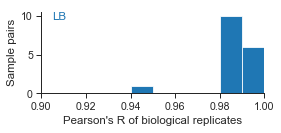

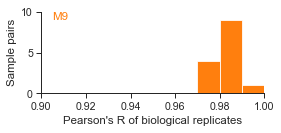

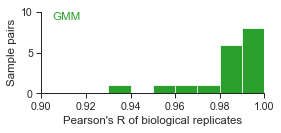

Median correlation coefficient : 0.988


In [117]:
strains=metadata.Strain.unique()
corr_coefs=pd.DataFrame(columns=['strain','screen','coef'])
for condition in ['LB','M9','GMM']:
    strains=list(metadata.loc[metadata.Screen==condition,'Strain'].values) #Keep strains that were assayed in this condition
    strains=list(set([s for s in strains if strains.count(s)==2])) #Keep samples with 2 biological replicates
    for s in strains:
        strain_samples=list(metadata[(metadata.Strain==s)&(metadata.Screen==condition)].index)#Get sample names
        corr_coefs.loc[len(corr_coefs)]=[s,condition,pearsonr(data[strain_samples[0]],data[strain_samples[1]])[0]] #Compute Pearson's R
    
for i,screen in enumerate(['LB','M9','GMM']):
    fig=plt.figure(figsize=(4,1.5))
    ax = fig.add_subplot(111)
    plt.hist(corr_coefs.loc[corr_coefs.screen==screen,'coef'],color=sns.color_palette()[i],edgecolor='white',bins=np.arange(0.9,1.1,0.01))
    plt.xlim([0.9,1])
    plt.xlabel('Pearson\'s R of biological replicates')
    plt.ylabel('Sample pairs')
    plt.yticks([0,5,10])
    plt.text(x=0.05,y=0.9,s=screen,transform=ax.transAxes,color=sns.color_palette()[i])
    sns.despine()
    plt.show()
print('Median correlation coefficient : '+str(round(corr_coefs.coef.median(),3)))

### Pooling replicates and calculating log2FC and gene scores

Considering the very reproducibility of CRISPRi experiments, we pooled the raw counts of biological replicates to increase sequencing depth. We then filtered sgRNAs having less than 20 reads in reference time points and normalized samples by sample size.

In [118]:
pooled_data=data.loc[:,[c for c in data.columns if ('_T0' in c)|(c=='MFDpir')]] #Keep initial time points and MFDpir sample

for condition in ['LB','M9','GMM']:
    strains=list(metadata.loc[metadata.Screen==condition,'Strain'].unique()) #Keep strains that were assayed in this condition
    for s in strains:
        pooled_data.loc[:,s+'_'+condition]=data.filter(regex=s+'_'+condition).dropna(axis=1,how='all').sum(axis=1)

#Remove guides where all T0 samples have less than 20 reads
pooled_data=pooled_data[pooled_data.filter(regex='_T0').max(axis=1)>20]
        
#For each strain, set guides that have <20 reads in T0 sample as NaN.
samples=[c for c in pooled_data.columns if ('_T0' not in c)&(c!='MFDpir')]
strains=list(set([s.split('_')[0] for s in samples]))

for s in strains:
    pooled_data.loc[data[s+'_T0']<20,[c for c in pooled_data.columns if (s in c)&('_T0' not in c)]]=np.nan

# Normalize read counts by sample size
norm_factors=np.mean(pooled_data.mean())/pooled_data.mean()
pooled_data=pooled_data*norm_factors
pooled_data.head()

HS_T0     E1114_T0    E1167_T0     H120_T0  \
CGGAGGTACTGGGTACATTT  590.526092   655.184659  462.437103  675.182072   
TGGCGATAATGCCGGCTATC  863.364096  1079.127673  848.828994  867.349277   
TTCCAGTTCACTGGTCTTCG  500.825926   449.636531  463.464741  457.046326   
AATTTCAGTGCCGTTCAGAT  326.408937   372.555982  420.303945  379.140702   
CTGCGGTAATAATTCCCGCC  186.875345   308.322192  275.406986  212.942038   

                        TA054_T0    TA447_T0     E101_T0  41-1Ti9_T0  \
CGGAGGTACTGGGTACATTT  591.431720  649.488974  608.788497  582.288701   
TGGCGATAATGCCGGCTATC  818.735701  820.553521  777.176804  779.946333   
TTCCAGTTCACTGGTCTTCG  460.125051  639.753593  514.231985  558.783469   
AATTTCAGTGCCGTTCAGAT  382.885833  375.507544  396.360170  361.125836   
CTGCGGTAATAATTCCCGCC  167.719443  180.799928  169.683602  149.578749   

                        TA280_T0     M114_T0     ...       TA280_GMM  \
CGGAGGTACTGGGTACATTT  614.437716  453.928310     ...      769.332130   
TGGCGATAATGCCGGCTATC  770.945436  786.809070     ...      944.341864   
TTCCAGTTCACTGGTCTTCG  528.455080  557.683352     ...      624.527122   
AATTTCAGTGCCGTTCAGAT  379.676136  456.089873     ...      448.629014   
CTGCGGTAATAATTCCCGCC  169.066982  178.328979     ...      242.526180   

                        M114_GMM   TA249_GMM   ROAR8_GMM  JJ1886_GMM  \
CGGAGGTACTGGGTACATTT  567.161754  581.492400  637.010643  744.121142   
TGGCGATAATGCCGGCTATC  778.457309  858.533393  741.329459  797.458496   
TTCCAGTTCACTGGTCTTCG  651.957996  675.470970  430.592560  604.923655   
AATTTCAGTGCCGTTCAGAT  465.684283  473.808623  563.765517  547.683568   
CTGCGGTAATAATTCCCGCC  230.756988  242.777972  177.563942  228.960351   

                      CFT073_GMM  APECO1_GMM   UTI89_GMM     S88_GMM  \
CGGAGGTACTGGGTACATTT  787.533138  834.714931  338.020888  938.164357   
TGGCGATAATGCCGGCTATC  796.344698  842.109970  545.153988  915.964995   
TTCCAGTTCACTGGTCTTCG  617.910616  608.241888  781.514458  808.828942   
AATTTCAGTGCCGTTCAGAT  484.635777  550.005963  728.142739  443.987247   
CTGCGGTAATAATTCCCGCC  197.158646  227.397423  182.988751  219.098055   

                      MG1655_GMM  
CGGAGGTACTGGGTACATTT  753.548733  
TGGCGATAATGCCGGCTATC  942.840175  
TTCCAGTTCACTGGTCTTCG  634.186614  
AATTTCAGTGCCGTTCAGAT  454.540596  
CTGCGGTAATAATTCCCGCC  182.057374  

[5 rows x 69 columns]

We further cleaned the data for each strain by discarding sgRNAs which contain a restriction pattern or which do not have a perfect match in the genome.

In [119]:
strains=['HS', 'TA280', 'TA054', 'MG1655', 'H120', 'ROAR8', '41-1Ti9', 'S88', 'TA447', 'E1167', 'M114', 'APECO1', 'UTI89', 'E101', 'JJ1886', 'E1114', 'CFT073', 'TA249']

# 1) Set read count to NaN when there is a restriction pattern
before_guide='TAGGTATAATACTAGT'
after_guide='GTTTTAGAGCTAGAA'
restriction_systems={
    '1':{'strain':'JJ1886','motif':'RTACNNNNGTG'},
    '2':{'strain':'S88','motif':'AGCANNNNNNTGA'},
    '3':{'strain':'JJ1886','motif':'AAAGNNNNGTT'},#RM system #2 found in JJ1886
    '4':{'strain':'APECO1','motif':'CCANNNNNNNCTTC'},
    '5':{'strain':'UTI89','motif':'CCANNNNNNNCTTC'},
    '6':{'strain':'TA280','motif':'GTAANNNNNRTTG'},
    '7':{'strain':'TA447','motif':'ACANNNNNNNNTGCC'},
    '8':{'strain':'E101','motif':'CYYANNNNNNTRCC'}}

for RM in restriction_systems.values():
    restricted=[]
    #For each RM system, find guides (also comprising the surrounding region) that are restricted
    for guide in pooled_data.index:
        guide_extended=before_guide+guide+after_guide
        if (len(nt_search(guide_extended,RM['motif']))>1)|(len(nt_search(str(Seq(guide_extended).reverse_complement()),RM['motif']))>1):
            restricted.append(guide)
    #Check which strains have the system and set read counts of restricted guides as NaN 
    cols=[c for c in pooled_data.columns if (RM['strain'] in c)&('_T0' not in c)]
    for c in cols:
        pooled_data.loc[restricted,c]=np.nan

# 2) Remove guides without a perfect match:
for strain in strains:
    guides_to_remove=[]
    library_strain=pd.read_csv('./Mapped_libraries/EcoCG_library_mapped_to_'+strain+'.txt',sep=',',index_col=0)
    guides_to_remove+=list(pooled_data[~pooled_data.index.isin(list(library_strain.target.unique())+control_guides)].index)
    guides_to_remove=list(set(guides_to_remove))
    pooled_data.loc[guides_to_remove,pooled_data.filter(regex=strain).columns]=np.nan

Log2FC values between initial and final time points were then be calculated. The library contains 20 non-targeting guides whose log2FC values should be around 0. We used these guides as negative controls to center the data. Gene scores were then calculated using the median log2FC per gene.

In [120]:
# 3) Calculate log2FC values
log2FC=pd.DataFrame(index=pooled_data.index)
for strain in strains:
    for screen in [c for c in pooled_data.columns if (strain in c)&('_T0' not in c)]: #Select strain samples (except T0) and calculate log2FC for each
        FC=pd.DataFrame({screen:np.log2((pooled_data[screen]+1)/(pooled_data[strain+'_T0']+1))},index=pooled_data.index)
        log2FC=pd.concat([log2FC,FC],axis=1,sort=False)
#Center log2FC values by removing the median of control guides
controls_median=log2FC.loc[control_guides].median()
log2FC=log2FC-controls_median

# 4) Merge with RefSeq annotations for K-12 MG1655
K12_library=pd.read_csv('./Mapped_libraries/Core library mapped to MG1665.3 genome.txt',sep=',',index_col=0)
for g in control_guides:
    K12_library.loc[len(K12_library)]=[g,np.nan,'control','control','control',np.nan,np.nan,np.nan,np.nan,0]
log2FC['target']=log2FC.index
log2FC=log2FC.loc[:,sorted(log2FC.columns)]
log2FC=pd.merge(log2FC,K12_library,on='target')

# 5) Calculate gene scores (median log2FC)
genes=list(set([g for g in log2FC.gene if (g not in ['NaN','[]']) and (type(g)==str)]))
medians=log2FC[samples+['gene']].groupby('gene').median()

# 6) Calculate median scores accross strains for each condition
for condition in ['LB','M9','GMM']:
    log2FC['median_'+condition]=log2FC.filter(regex=condition).median(axis=1)
    medians['median_'+condition]=medians.filter(regex=condition).median(axis=1)

medians=pd.merge(medians,K12_library[['locus_tag','gene_type','gene','strand','gene_left','gene_right','product']].drop_duplicates(),on='gene')
medians.index=medians.gene
medians=medians.drop('gene',axis=1)

C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


## Prediction of K-12 essential genes

We use Goodall *et al.* (2018) as a gold standard for gene essentiality in *E. coli* K-12.

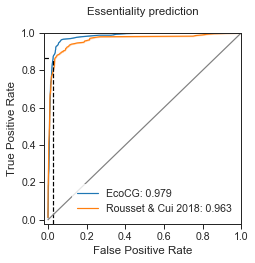

Using -3 as a threshold, the True Positive Rate is 86.27% and the False Positive Rate is 2.66%


In [121]:
tradis=pd.read_csv('Goodall_et_al_2018.csv',sep=';')[['Gene','Essential']]
tradis=tradis.rename(columns={'Gene':'gene'})

new_data=medians.loc[:,['MG1655_LB']]
new_data['gene']=new_data.index
new_data.index=range(0,len(new_data))
rousset2018=pd.read_csv('Rousset_et_al_2018.csv')
rousset2018=rousset2018[['gene','median_coding']]
merged=pd.merge(tradis,pd.merge(rousset2018.dropna(),new_data,on='gene'),on='gene')
merged=merged.rename(columns={'MG1655_LB':'EcoCG','median_coding':'Rousset & Cui 2018','Essential':'essential'})

fpr_tpr=[]
roc_auc=[]
datasets=['EcoCG','Rousset & Cui 2018']
for test in datasets:
    X = merged.dropna()[test]
    y = merged.dropna()['essential']
    model = sm.GLM(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    fpr_tpr.append(metrics.roc_curve(y, predictions))
    roc_auc.append(metrics.auc(fpr_tpr[-1][0], fpr_tpr[-1][1]))

tpr=len(merged[(merged.essential)&(merged.EcoCG<(-3))])/len(merged[(merged.essential)])
fpr=len(merged[(merged.essential==False)&(merged.EcoCG<(-3))])/len(merged[(merged.essential==False)])

sns.set_style('ticks')
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(3.7,3.8))
plt.title('Essentiality prediction\n')# ('+str(len(merged))+' genes)')
c=['r','b','g','y','o']
for i,roc in enumerate(fpr_tpr):
    sns.lineplot(roc[0], roc[1], label = str(datasets[i])+': %0.3f' % roc_auc[i])
plt.axvline(fpr,0,tpr,color='black',linestyle='--')
plt.axhline(tpr,0,fpr,color='black',linestyle='--')
plt.plot([0, 1], [0, 1],'grey')
plt.xlim([-0.02, 1])
plt.ylim([-0.02, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend().get_frame().set_linewidth(0.0)
plt.tight_layout()
plt.show()
print('Using -3 as a threshold, the True Positive Rate is '+str(round(tpr*100,2))+'% and the False Positive Rate is '+str(round(fpr*100,2))+'%')

We hypothesized that the improved design of the EcoCG library enabled a better prediction of essential genes than our previous library (Rousset *et al.*, 2018). For both datasets, we calculated the standard-deviation (SD) of the log2FC values of each gene. Since the EcoCG library only has 3.4 guides per gene on average, we also calculated the SD of log2FC values in our previous library by selecting only 3 guides per gene.

100%|█████████████████████████████████████████████████████████████████████████████| 3021/3021 [00:14<00:00, 204.33it/s]
C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


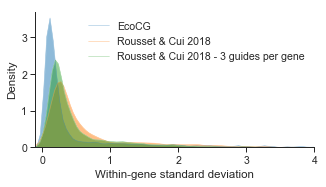

In [122]:
rousset2018_log2FC=pd.read_csv('Rousset_et_al_2018_log2FC.csv')
rousset2018_log2FC=rousset2018_log2FC.loc[rousset2018_log2FC.coding==True,['gene','log2FC']]
merged=pd.concat([log2FC[['MG1655_LB','gene']].groupby('gene').std(),rousset2018_log2FC.groupby('gene').std()],axis=1,join='inner')

SD_combinations=[]
for gene in tqdm(merged.index):
    guides=rousset2018_log2FC.loc[rousset2018_log2FC.gene==gene,'log2FC']
    if len(guides)<4: #if there are 3 guides or less, there is no need to do permutations
        SD_combinations.append(guides.std())
    else: #Else, we perform all permutations of 3 guides(depending of the number of guides)
        combinations=[i for i in itertools.combinations(guides, 3)] #Reference all possible guides combinations and the average SD
        SD_combinations.append(np.mean([np.std(idx) for idx in [i for i in itertools.combinations(guides, 3)]]))

merged['Rousset & Cui 2018 - 3 guides per gene']=SD_combinations
merged.columns=['EcoCG','Rousset & Cui 2018','Rousset & Cui 2018 - 3 guides per gene']

plt.figure(figsize=(5,2.5))
for dataset in merged.columns:
    sns.kdeplot(merged[dataset],label=dataset,shade=True,alpha=0.5,linewidth=0.5)
plt.xlim(-0.1,4)
plt.xlabel('Within-gene standard deviation')
plt.ylabel('Density')
plt.legend().get_frame().set_linewidth(0.0)
sns.despine()
plt.show()

## Overall genetic requirements of *E. coli*

We first investigated the overall requirements of the *E. coli* species by calculating the median gene score across all strains. Comparison of median gene scores between LB and M9 highlighted auxotrophy genes which are required in minimal medium but not in rich LB medium.

C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


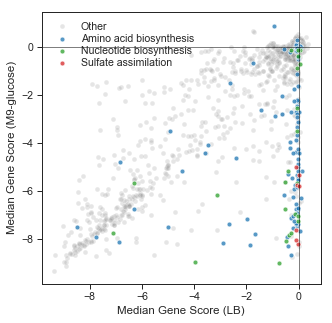

In [124]:
MG1655=[r for r in SeqIO.parse('MG1655-3.0.gb','genbank')][0]
features=[f for f in MG1655.features if f.type=='gene']
aa=open('amino_acid_biosynthesis_genes_KEGG.txt','r')
aa_genes=pd.DataFrame(columns=['kegg','function'])
for line in aa.readlines():
    aa_genes.loc[line[4:9]]=[line[21:27],line[28:].split(' |')[0]]
gene_names=[]
for idx in aa_genes.index:
    for f in features:
        if 'locus_tag' in f.qualifiers:
            if f.qualifiers['locus_tag'][0]==idx:
                gene_names.append(f.qualifiers['gene'][0])
aa_genes.loc[:,'gene']=gene_names

CDS=medians.loc[medians.gene_type=='CDS']
CDS.loc[:,'gene']=CDS.index
CDS.loc[:,'class']='none'
CDS.loc[CDS.index.isin(aa_genes.gene),'class']='Amino acid biosynthesis'
CDS.loc[(CDS.index.str.contains('pur'))|(CDS.index.str.contains('pyr')),'class']='Nucleotide biosynthesis'
CDS.loc[CDS.index.isin(['cysC','cysD','cysN','cysG','cysH','cysI','cysJ']),'class']='Sulfate assimilation'

plt.figure(figsize=(5,5))
colors=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[3]]
plt.axvline(0,color='black',linewidth=1,alpha=0.5)
plt.axhline(0,color='black',linewidth=1,alpha=0.5)
sns.scatterplot('median_LB','median_M9',data=CDS.loc[CDS['class']=='none'],color='grey',label='Other',alpha=0.2)
for i,c in enumerate(['Amino acid biosynthesis','Nucleotide biosynthesis','Sulfate assimilation']):
    sns.scatterplot('median_LB','median_M9',data=CDS.loc[CDS['class']==c],color=colors[i],label=c,alpha=0.75)
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.2)
plt.xlabel('Median Gene Score (LB)')
plt.ylabel('Median Gene Score (M9-glucose)')
plt.show()

Similarly, comparison of median gene scores in LB and GMM highlighted medium-specific essential genes associated with respiration and fermentation.

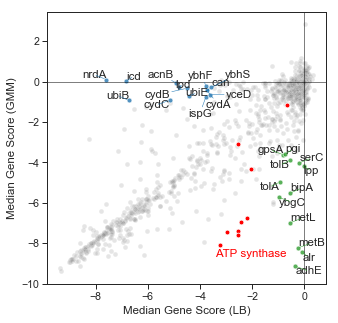

In [125]:
plt.figure(figsize=(5,5))
colors=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[3]]
plt.axvline(0,color='black',linewidth=1,alpha=0.5)
plt.axhline(0,color='black',linewidth=1,alpha=0.5)
CDS=medians[medians.gene_type=='CDS']
sns.scatterplot('median_LB','median_GMM',data=CDS,color='grey',alpha=0.2)

sns.scatterplot('median_LB','median_GMM',data=CDS.loc[(CDS.median_LB<(-3.5))&(CDS.median_GMM>(-1))],color=colors[0],alpha=0.75)
texts=[]
for gene in CDS[(CDS.median_LB<(-3.5))&(CDS.median_GMM>(-1))].index:
    texts.append(plt.text(CDS.loc[gene,'median_LB'],CDS.loc[gene,'median_GMM'],gene))
adjust_text(texts, force_points=0.2, force_text=0.8, expand_points=(1,1), expand_text=(0.8,0.8),
            arrowprops=dict(arrowstyle="-", color=colors[0], lw=0.5))
    
sns.scatterplot('median_LB','median_GMM',data=CDS.loc[(CDS.median_GMM<(-3.5))&(CDS.median_LB>(-1))],color=colors[1],alpha=0.75)
texts=[]
for gene in CDS[(CDS.median_GMM<(-3.5))&(CDS.median_LB>(-1))].index:
    texts.append(plt.text(CDS.loc[gene,'median_LB'],CDS.loc[gene,'median_GMM'],gene))
adjust_text(texts, force_points=0.2, force_text=0.8, expand_points=(1,1), expand_text=(0.8,0.8),
            arrowprops=dict(arrowstyle="-", color=colors[1], lw=0.5))

CDS.loc[(CDS.index.str.contains('atp')),'class']='ATP synthase'
ax=sns.scatterplot('median_LB','median_GMM',data=CDS.loc[CDS['class']=='ATP synthase'],color='red')
plt.text(x=0.6,y=0.1,s='ATP synthase', transform=ax.transAxes,color='red')
plt.xlabel('Median Gene Score (LB)')
plt.ylabel('Median Gene Score (GMM)')
plt.show()


## Core and pan-essential genomes

We then explored how many genes are essential in at least one strain and how frequently these genes are essential. 

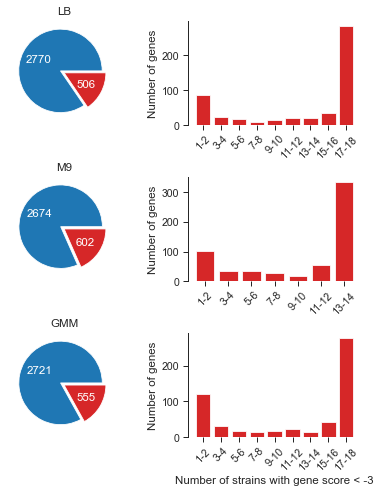

In [126]:
threshold=-3
medians_binary={}
essential={}
for screen in ['LB','M9','GMM']:
    #We first make essentiality data binary (1 if essential, else 0)
    medians_binary[screen]=pd.DataFrame(index=medians[medians.gene_type=='CDS'].index)
    for c in medians.filter(regex=screen).drop('median_'+screen,axis=1):
        medians_binary[screen][c]=[1 if s<threshold else 0 for s in medians.loc[medians.gene_type=='CDS',c]]
    essential[screen]=medians_binary[screen].sum(axis=1)

plt.figure(figsize=(6,7))
for i,screen in enumerate(['LB','M9','GMM']):
    plt.subplot(3,2,2*i+1)
    plt.title(screen)
    _,_,autotexts=plt.pie([len(essential[screen][essential[screen]==0]),len(essential[screen][essential[screen]>0])],
        autopct=lambda p: '{:.0f}'.format(p*len(essential[screen])/100),
        explode=(0.1,0),
        startangle=0,
    colors=["#1f77b4",'#d62728'])
    for autotext in autotexts:
        autotext.set_color('white')
    
    plt.subplot(3,2,2*i+2)
    labels=['1-2','3-4','5-6','7-8','9-10','11-12','13-14','15-16','17-18']
    g=plt.bar(labels[:int(max(essential[screen])/2)],[list(essential[screen][essential[screen]>0]).count(i)+list(essential[screen][essential[screen]>0]).count(i+1) for i in range(1,max(essential[screen]),2)],color='#d62728')
    if i==2:
        plt.xlabel('Number of strains with gene score < '+str(threshold))
    else:
        plt.xlabel('')
    plt.xticks(rotation=45,ha='center')
    plt.ylabel('Number of genes')
    sns.despine(bottom=True)
plt.tight_layout()
plt.show()

We can tentatively use this data to define a core-essential genome, i.e. genes that are virtually essential in all strains of the species, and a pan-essential genome, i.e. genes that are essential in at least one strain of the species. In order to investigate how the choice and number of strains impacts these set of genes, we computed the core-essential genome and pan-essential genome for various sets of strains. 

In [127]:
#Calculate core- and pan-essential genome
core={}

#We first open the pangenome: this file was generated by clustering proteins from the 18 strains with MMseqs2 (80% identity threshold)
pan_genome=open('Pan_genome.txt','r')
pan_genome=pd.DataFrame({'genes':pan_genome.readlines()})

for medium in ['LB','M9','GMM']:
    #Get all strains with data
    columns=[c for c in medians.filter(regex=medium).columns if 'median' not in c]    
    core[medium]=pd.DataFrame(columns=['nb','core_essential','core_genome','pan_essential','pan_genome'])
    for n in tqdm(range(1,len(columns)+1)):
        combinations=[i for i in itertools.combinations(columns, n)]
        #For each size
        for i in range(min(250,len(combinations))):
            cols=list(combinations[np.random.randint(len(combinations))])
            
            #Select genes present in at least one of the strains:
            panG=pan_genome[pan_genome.genes.str.contains('|'.join([c.split('_')[0] for c in cols]))]
            #Select genes present in all strains:
            coreG=panG[panG.genes.isin([item for item in panG.genes if all(s in item for s in [c.split('_')[0] for c in cols])])]
            
            temp2=medians.loc[medians.gene_type=='CDS',cols]
            core[medium].loc[len(core[medium])]=[n,
                                                 len(temp2[temp2.max(axis=1)<(-3)]), #essential in all strains
                                                 len(coreG),
                                                 len(temp2[temp2.min(axis=1)<(-3)]), #essential in at least one strain
                                                 len(panG)  ]
for medium in ['LB','M9','GMM']:
    core[medium]['medium']=medium
cores=pd.concat([core['LB'],core['M9'],core['GMM']])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:16<00:00,  8.33s/it]


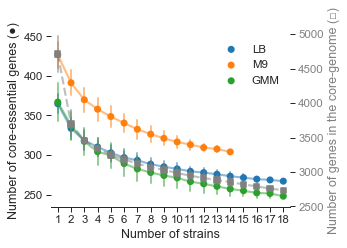

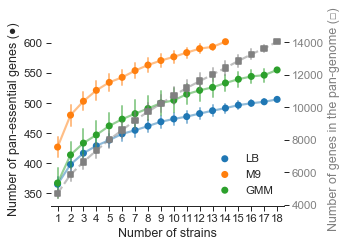

In [129]:
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.3)

fig=plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
sns.set_style('ticks')
g=sns.pointplot('nb','core_essential',data=cores,hue='medium',ci='sd',errwidth=2,scale=1)
plt.legend().get_frame().set_linewidth(0.0)
plt.setp(g.lines, alpha=.5)
plt.xticks(np.arange(-1,19,2),labels=np.arange(0,19,2))
plt.xlabel('Number of strains')
plt.ylabel('Number of core-essential genes (●)')
sns.despine()
ax2 = ax1.twinx()
g2=sns.pointplot(cores.nb,cores.core_genome,markers='s',color='grey',linestyles='--',ci='sd',errwidth=2,scale=1,alpha=0.2)
plt.setp(g2.lines, alpha=.5)
ax2.set_ylabel('Number of genes in the core-genome (□)', color='grey')
ax2.set_ylim([2500,5000])
for tl in ax2.get_yticklabels():
    tl.set_color('grey')
sns.despine(left=True)
plt.tight_layout()
plt.show()

fig=plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
sns.set_style('ticks')
g=sns.pointplot('nb','pan_essential',data=cores,hue='medium',ci='sd',errwidth=2,scale=1)
plt.legend().get_frame().set_linewidth(0.0)
plt.setp(g.lines, alpha=.5)
plt.xticks(np.arange(-1,19,2),labels=np.arange(0,19,2))
plt.xlabel('Number of strains')
plt.ylabel('Number of pan-essential genes (●)')
ax2 = ax1.twinx()
g2=sns.pointplot(cores.nb,cores.pan_genome,color='grey',markers='s',linestyles='--',ci='sd',errwidth=2,scale=1,alpha=0.8)
plt.setp(g2.lines, alpha=.5)
ax2.set_ylabel('Number of genes in the pan-genome (□)', color='grey')
for tl in ax2.get_yticklabels():
    tl.set_color('grey')
sns.despine(left=True)
plt.tight_layout()
plt.show()

Interestingly, the size of the core genome and the size of the core- essential genome converge at a similar pace. As a result, the fraction of the core genome that is essential in all strains is roughly independent from the number of strains under consideration (e.g. ~9-10% of the core genome in LB). The set of core genes that are essential in at least one strain keeps increasing with the addition of new strains, showing that our results probably only reveal a fraction of the existing differences at the species level.

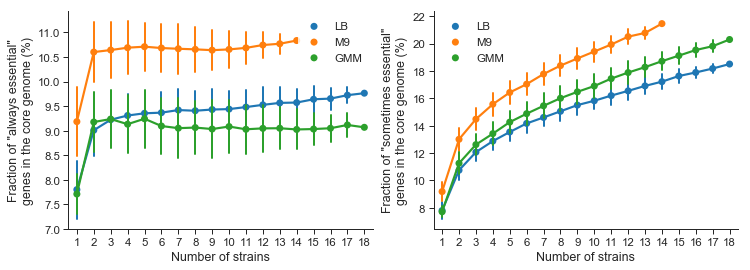

In [130]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.pointplot(cores.nb,100*cores.core_essential/cores.core_genome,hue=cores['medium'],ci='sd',errwidth=2)
plt.ylabel('Fraction of "always essential"\ngenes in the core genome (%)')
plt.xlabel('Number of strains')
sns.despine()
plt.legend().get_frame().set_linewidth(0.0)
plt.subplot(122)
sns.pointplot(cores.nb,100*cores.pan_essential/cores.core_genome,hue=cores['medium'],ci='sd',errwidth=2)
plt.ylabel('Fraction of "sometimes essential"\ngenes in the core genome (%)')
plt.xlabel('Number of strains')
sns.despine()
plt.legend().get_frame().set_linewidth(0.0)
plt.show()

## The relationship between gene expression and essentiality

Since gene essentiality has been linked to a higher gene expression level, we wondered to what extent changes in gene essentiality are reflected by changes in gene expression level. We generated RNA-sequencing (RNA-seq) data for 16 strains during growth in exponential phase in LB and compared the expression of core genes.

In [131]:
rnaseq=pd.read_csv('Counts_table_core_genes_RNAseq.csv',index_col=0)
merged=pd.concat([rnaseq,medians],join='inner',axis=1)

As previously observed, expression level and essentiality were correlated, with a higher expression level for essential genes.

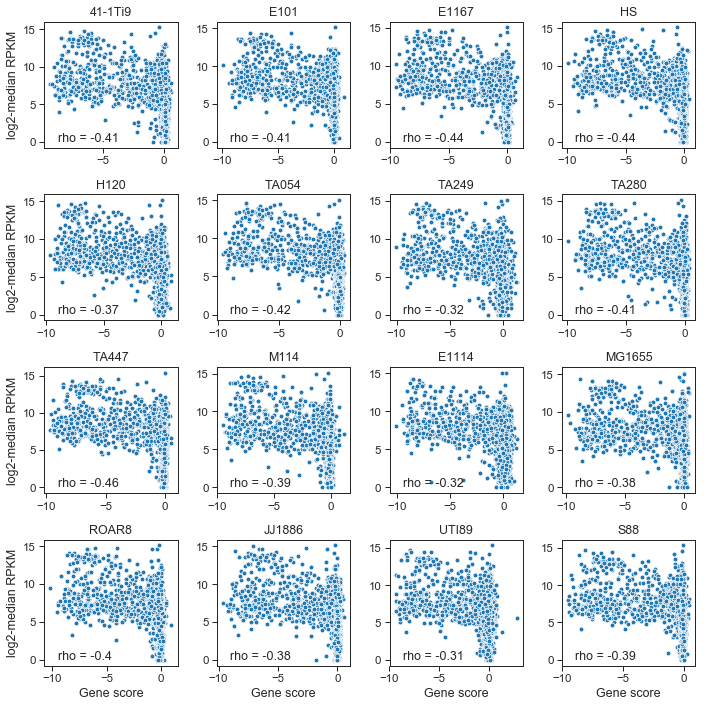

In [132]:
fig=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))
strains=['41-1Ti9','E101','E1167','HS','H120','TA054','TA249','TA280','TA447','M114','E1114','MG1655','ROAR8','JJ1886','UTI89','S88']

for i,strain in enumerate(strains):
    table=merged[[strain,strain+'_LB']]
    ax=plt.subplot(4,4,i+1)
    sns.scatterplot(strain+'_LB',strain,data=table)
    spearman=spearmanr(table.dropna()[strain],table.dropna()[strain+'_LB'])
    plt.text(x=0.1,y=0.05,transform=ax.transAxes,s="rho = "+str(round(spearman[0],2)))
    plt.title(strain)
    if i>11:
        plt.xlabel('Gene score')
    else:
        plt.xlabel('')
    if int((i)/4)==(i)/4:
        plt.ylabel('log2-median RPKM')
    else:
        plt.ylabel('')
plt.tight_layout()
plt.show()

We selected 87 genes that were variably essential between the 16 strains assayed in RNA-seq experiments. Considering all strains together, these “variably essential” genes tend to be more expressed than genes that are never essential but less expressed than genes that are always essential.

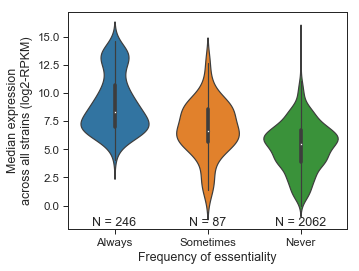

Always vs sometimes p-value 5.019039782614655e-10
Sometimes vs never p-value 3.385734502818207e-09


In [133]:
LB=medians[medians.gene_type=='CDS'].filter(regex='LB').drop(['APECO1_LB','CFT073_LB'],axis=1)
threshold_low=-3
threshold_high=-1
sometimes_essential=LB[(LB.min(axis=1)<threshold_low)&(LB.max(axis=1)>threshold_high)].index
always_essential=LB[LB.max(axis=1)<threshold_low].index
never_essential=LB[LB.min(axis=1)>threshold_high].index

rnaseq_essentiality_frequency=rnaseq.copy()
freq=[]
for gene in rnaseq_essentiality_frequency.index:
    if gene in always_essential:
        freq.append('Always')
    elif gene in sometimes_essential:
        freq.append('Sometimes')
    elif gene in never_essential:
        freq.append('Never')
    else:
        freq.append('NA')
rnaseq_essentiality_frequency['frequency']=freq
rnaseq_essentiality_frequency=rnaseq_essentiality_frequency[rnaseq_essentiality_frequency.frequency!='NA'].sort_values('frequency')

plt.figure(figsize=(5,4))
categories=['Always','Sometimes','Never']

ax=sns.violinplot('frequency','median',data=rnaseq_essentiality_frequency,order=categories)
plt.xlabel('Frequency of essentiality')
plt.ylabel('Median expression\nacross all strains (log2-RPKM)')
for tick,label in zip(range(len(categories)),ax.get_xticklabels()):
    ax.text(range(len(categories))[tick], -1.8,'N = '+str(len(rnaseq_essentiality_frequency[rnaseq_essentiality_frequency.frequency==categories[tick]])),horizontalalignment='center')
plt.show()

print("Always vs sometimes p-value",st.mannwhitneyu(rnaseq_essentiality_frequency.loc[rnaseq_essentiality_frequency.frequency=='Always','median'],rnaseq_essentiality_frequency.loc[rnaseq_essentiality_frequency.frequency=='Sometimes','median'],alternative='two-sided')[1])
print("Sometimes vs never p-value",st.mannwhitneyu(rnaseq_essentiality_frequency.loc[rnaseq_essentiality_frequency.frequency=='Never','median'],rnaseq_essentiality_frequency.loc[rnaseq_essentiality_frequency.frequency=='Sometimes','median'],alternative='two-sided')[1])

When considering each “variably essential” gene individually, we found no correlation between CRISPRi fitness and its gene expression level across the 16 strains. This suggests that a shift is essentiality is not associated with a shift in expression level. 

C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


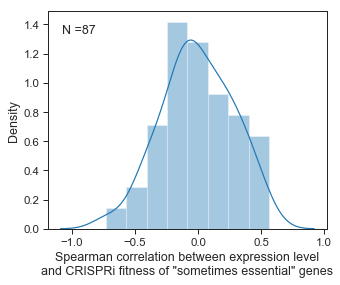

In [134]:
sometimes_df=pd.DataFrame(columns=['RPKM','fitness'])
rho=pd.DataFrame(columns=['rho'])
sometimes_essential_genes=rnaseq_essentiality_frequency[rnaseq_essentiality_frequency.frequency=='Sometimes'].index
for gene in sometimes_essential_genes:
    fitness=pd.DataFrame({'fitness':LB.loc[gene].transpose()})
    fitness.index=[c.split('_')[0] for c in fitness.index]
    expression=pd.DataFrame({'expression':rnaseq.loc[gene].transpose()})
    temp=pd.concat([fitness,expression],axis=1).drop('median')
    rho.loc[gene]=spearmanr(temp.dropna().fitness,temp.dropna().expression)[0]
    
plt.figure(figsize=(5,4))
ax=sns.distplot(rho.rho)
plt.text(x=0.05,y=0.9,transform=ax.transAxes,s='N ='+str(len(sometimes_essential_genes)))
plt.xlabel('Spearman correlation between expression level\nand CRISPRi fitness of "sometimes essential" genes')
plt.ylabel('Density')
plt.show()

## The impact of phylogeny on gene expression and essentiality

We then investigated the relevance of vertical evolution to the variations in gene expression and essentiality. For each pairs of strains, we calculated the Spearman correlation of their gene expression profiles, the Spearman correlation of their CRISPRi fitness profiles as well as their phylogenetic distance

In [135]:
from Bio import Phylo

t = Phylo.read('parsnp.tree', 'newick')

phylogenetic_distances = {}
for x, y in itertools.combinations(t.get_terminals(), 2):
    v = t.distance(x, y)
    phylogenetic_distances[x.name] = phylogenetic_distances.get(x.name, {})
    phylogenetic_distances[x.name][y.name] = v
    phylogenetic_distances[y.name] = phylogenetic_distances.get(y.name, {})
    phylogenetic_distances[y.name][x.name] = v
for x in t.get_terminals():
    phylogenetic_distances[x.name][x.name] = 0
phylogenetic_distances = pd.DataFrame(phylogenetic_distances)

from scipy.spatial import distance
from scipy.spatial.distance import hamming

def get_distances_df(medians,phylogenetic_distances):
    '''
    This function compiles the evolutionary distance (phylogenetic_distances) and the experimental similarity (Spearman's correlation).
    The Gene Repertoire Relatedness index (GRR) between two genomes was defined as the number of common gene families (the intersection) divided by the number of genes in the smallest genome
    '''
    
    distances=pd.DataFrame(columns=['strain1','strain2','core_genome_alignment','spearman'])
    strains=medians.columns
    binary_medians=medians.copy()
    binary_medians[:]=np.where(binary_medians<(-3),1,0)
    for i,strain1 in enumerate(strains):
        for strain2 in strains[i+1:]:
            distances.loc[len(distances)]=[strain1,strain2,
                                          phylogenetic_distances.loc[phylogenetic_distances.index.str.contains(strain1),phylogenetic_distances.columns.str.contains(strain2)].values[0][0],
                                          spearmanr(medians.dropna()[strain1],medians.dropna()[strain2])[0]]
    return distances

We observed a strong negative correlation between the phylogenetic distance of pairs of strains and the similarity in their gene expression profile (Spearman’s rho = -0.52, p < 1e-10), i.e. closely-related strains have more similar expression profiles. Interestingly, K-12 MG1655 seems to be an outlier and discarding it from this analysis markedly improved the correlation (rho = -0.69, p < 1e-15) 

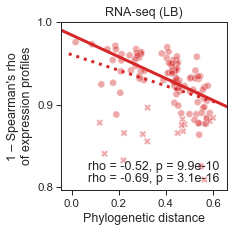

In [136]:
x='core_genome_alignment'
y='spearman'
plt.figure(figsize=(3.5,3.4))
distances=get_distances_df(rnaseq.drop('median',axis=1),phylogenetic_distances)
distances['MG?']=[True if 'MG1655' in list(distances.loc[i,['strain1','strain2']]) else False for i in distances.index]
ax=sns.regplot(distances[x],distances[y],scatter_kws={'s':0,'linewidth':1,'edgecolor':'w','alpha':0.4},line_kws={'linewidth':3,'linestyle':':'},ci=False,color='#d62728')
sns.scatterplot(x,y,s=50,linewidth=1,edgecolor='w',style='MG?',alpha=0.4,color="#d62728",data=distances)
spearman1=spearmanr(distances[x],distances[y])
plt.text(x=0.16,y=0.12,transform=ax.transAxes,s="rho = "+str(round(spearman1[0],2))+', p = '+str(round(spearman1[1],int(np.log10(1/spearman1[1]))+2)))

without_MG=distances[(distances.strain1!='MG1655')&(distances.strain2!='MG1655')]
sns.regplot(without_MG[x],without_MG[y],scatter_kws={'s':0,'linewidth':1,'edgecolor':'w','alpha':0.4},line_kws={'linewidth':3},ci=False,color='#d62728')
spearman2=spearmanr(without_MG[x],without_MG[y])
plt.text(x=0.16,y=0.05,transform=ax.transAxes,s="rho = "+str(round(spearman2[0],2))+', p = '+str(round(spearman2[1],int(np.log10(1/spearman2[1]))+2)))
ax.legend_.remove()
plt.xlabel('Phylogenetic distance')
plt.ylabel('1 – Spearman\'s rho\nof expression profiles')
plt.title('RNA-seq (LB)')
plt.yticks([0.8,0.9,1])
plt.tight_layout()
plt.show()

To visualize this trend in more details, we performed the same analysis considering each strain individually:

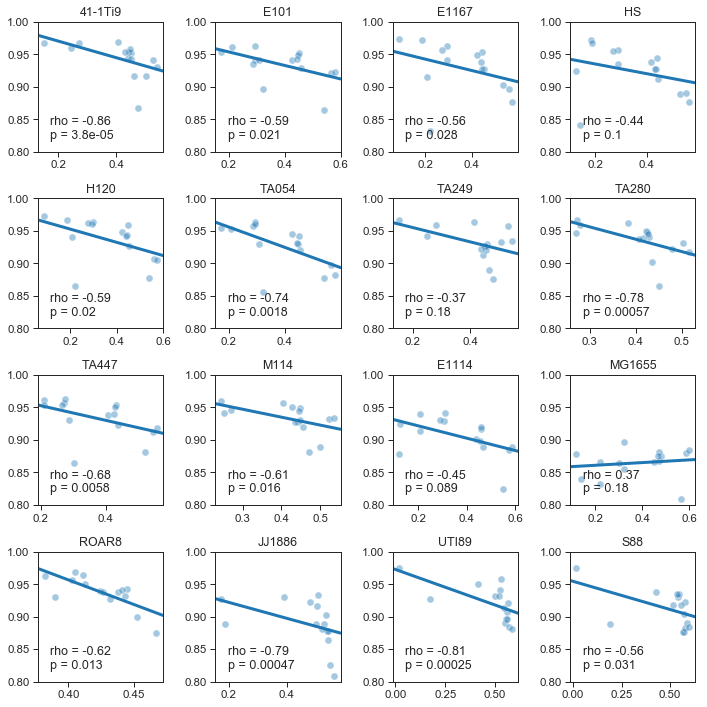

In [137]:
distances=get_distances_df(rnaseq.drop('median',axis=1),phylogenetic_distances)
fig=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))
for i,s in enumerate(strains):
    ax=plt.subplot(4,4,i+1)
    temp=distances[((distances.strain1==s)|(distances.strain2==s))]
    spearman=spearmanr(temp.core_genome_alignment,temp['spearman'])
    plt.title(s)
    plt.text(x=0.1,y=0.1,transform=ax.transAxes,s="rho = "+str(round(spearman[0],2))+'\np = '+str(round(spearman[1],int(np.log10(1/spearman[1]))+2)))
    ax=sns.regplot(temp.core_genome_alignment,temp['spearman'],scatter_kws={'s':50,'linewidth':1,'edgecolor':'w','alpha':0.4},line_kws={'linewidth':3},ci=False,label='all')
    plt.ylim([0.8,1])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

We then conducted the same analysis with the CRISPRi fitness profiles. 

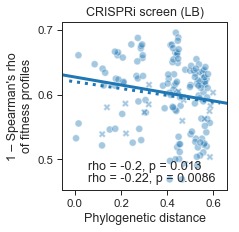

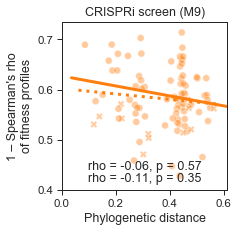

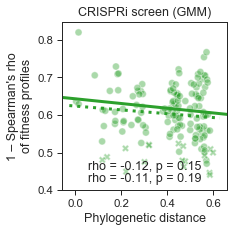

In [138]:
x='core_genome_alignment'
y='spearman'
for i,screen in enumerate(['LB','M9','GMM']):
    temp=medians[medians.gene_type=='CDS'].filter(regex=screen).drop('median_'+screen,axis=1).drop_duplicates()
    temp.columns=[c.split('_')[0] for c in temp.columns]
    distances=get_distances_df(temp,phylogenetic_distances)
    distances['MG?']=[True if 'MG1655' in list(distances.loc[i,['strain1','strain2']]) else False for i in distances.index]

    plt.figure(figsize=(3.5,3.4))
    ax=sns.regplot(distances.core_genome_alignment,distances[y],scatter_kws={'s':0,'linewidth':1,'edgecolor':'w','alpha':0.4},line_kws={'linewidth':3,'linestyle':':'},ci=False,color=sns.color_palette()[i])
    sns.scatterplot(x,y,s=50,linewidth=1,edgecolor='w',style='MG?',alpha=0.4,color=sns.color_palette()[i],data=distances)
    spearman1=spearmanr(distances[x],distances[y])
    plt.text(x=0.16,y=0.12,transform=ax.transAxes,s="rho = "+str(round(spearman1[0],2))+', p = '+str(round(spearman1[1],int(np.log10(1/spearman1[1]))+2)))
    without_MG=distances[(distances.strain1!='MG1655')&(distances.strain2!='MG1655')]
    sns.regplot(without_MG.core_genome_alignment,without_MG[y],scatter_kws={'s':0,'linewidth':1,'edgecolor':'w','alpha':0.4},line_kws={'linewidth':3},ci=False,color=sns.color_palette()[i])
    spearman2=spearmanr(without_MG[x],without_MG[y])
    plt.text(x=0.16,y=0.05,transform=ax.transAxes,s="rho = "+str(round(spearman2[0],2))+', p = '+str(round(spearman2[1],int(np.log10(1/spearman2[1]))+2)))
    ax.legend_.remove()
    plt.title('CRISPRi screen ('+screen+')')
    plt.xlabel('Phylogenetic distance')
    plt.ylabel('1 – Spearman\'s rho\nof fitness profiles')
    plt.xticks([0,0.2,0.4,0.6])
    
    y_ticks=ax.get_ylim()
    plt.yticks(np.arange(round(y_ticks[0],1),round(y_ticks[1],1)+0.1,0.1))
    plt.tight_layout()
    plt.show()


We also investigated if strains from the same phylogroup have more similar fitness profiles than strains from different phylogroups. The following analysis shows that this is not the case.

3276


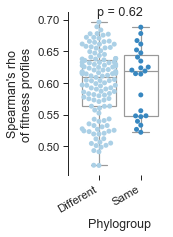

3276


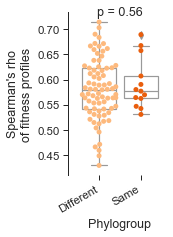

3276


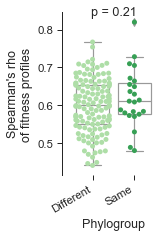

In [139]:
collection=pd.read_excel('Phylogroups.xlsx')

colors=['Blues','Oranges','Greens']
y='spearman'
for i,screen in enumerate(['LB','M9','GMM']):
    temp=medians[medians.gene_type=='CDS'].filter(regex=screen).drop('median_'+screen,axis=1)
    #Select genes that are essential in 2 to 16 strains only.
    #temp=temp.loc[[i for i in temp.index if (len(temp.loc[i][temp.loc[i]<(-3)])>1)&(len(temp.loc[i][temp.loc[i]<(-3)])<(temp.shape[1]-1))]]
    print(len(temp))
    temp.columns=[c.split('_')[0] for c in temp.columns]
    distances=get_distances_df(temp,phylogenetic_distances)
    distances['phylogroup1']=[collection.loc[collection['Strain name']==s,'Phylogenetic group MLST'].values[0] for s in distances['strain1']]
    distances['phylogroup2']=[collection.loc[collection['Strain name']==s,'Phylogenetic group MLST'].values[0] for s in distances['strain2']]
    distances['same_phylogroup']=[True if distances.loc[i,'phylogroup1']==distances.loc[i,'phylogroup2'] else False for i in distances.index ]
    
    plt.figure(figsize=(1.5,3))
    sns.set_style('ticks')
    g=sns.boxplot(x='same_phylogroup',y=y,color='white',data=distances)
    sns.swarmplot('same_phylogroup',y,data=distances,palette=sns.color_palette(colors[i],2))
    g.set(xlabel='',ylabel='Spearman\'s rho\nof fitness profiles')
    g.set_xticklabels(labels=['Different','Same'],rotation=30,ha='right')
    plt.xlabel('Phylogroup')
    sns.despine(offset=10,bottom=True)
    pvalue=st.ttest_ind(distances.loc[distances.same_phylogroup,y],distances.loc[~distances.same_phylogroup,y])[1]
    plt.text(x=0.5,y=0.98,transform=g.transAxes,s="p = "+str(round(pvalue,2)),ha='center')
    plt.show()

Considering each “variably essential” gene individually, We then wondered whether pairs of strains that share an essential gene tend to be more closely related than pairs for which the gene is differentially essential. We therefore selected gene that are essential in at least 2 strains while being dispensable in at least 2 strains. In order to avoid redundancy, we removed the upstream gene of an operon if a polar effect in the downstream gene explained the fitness effect (for example, both *ycaR* and *kdsB* are variably essential, but the fitness effect of *ycaR* is explained by a polar effect in *kdsB*). For each of these genes, we calculated the correlation between the phylogenetic distance of pairs of strains and the absolute difference in their gene score. This showed that there is a correlation for a handful of genes whose contribution to fitness changes in some clades, but no signal could be seen for the majority of “variably essential” gene.

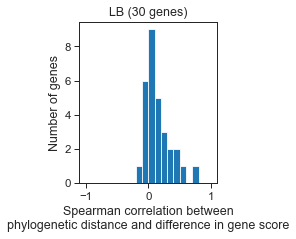

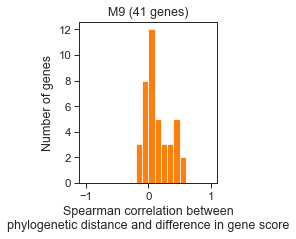

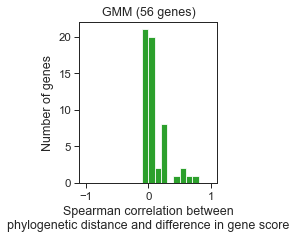

In [140]:
genes_to_remove={'LB':['glnL','pstC','pstS','ppdC','ycaR'],
                'M9':['fepD','ftsE','ycaR','mrdA','rlmH','rsfS','yajC','secD','mreB','mreC'],
                'GMM':["aroB",'glnL','ycaR','pstA']
                }

for i,screen in enumerate(['LB','M9','GMM']):
    temp=medians[medians.gene_type=='CDS'].filter(regex=screen).drop('median_'+screen,axis=1).drop_duplicates()
    temp=temp.loc[[i for i in temp.index if (len(temp.loc[i][temp.loc[i]<(-3)])>1)&(len(temp.loc[i][temp.loc[i]>(-1)])>1)]]
    temp.columns=[c.split('_')[0] for c in temp.columns]
    dist=pd.DataFrame(columns=['strain1','strain2','core_genome_alignment','GRR','1-GRR'])
    
    temp=temp.drop(genes_to_remove[screen])
    
    for j,strain1 in enumerate(temp.columns):
        for strain2 in temp.columns[j+1:]:
            dist.loc[len(dist)]=[strain1,strain2,
                                 phylogenetic_distances.loc[phylogenetic_distances.index.str.contains(strain1),phylogenetic_distances.columns.str.contains(strain2)].values[0][0],
                                 len(gene_matrix[(gene_matrix[strain1]+gene_matrix[strain2])==2])/gene_matrix[[strain1,strain2]].sum().min(),
                                 1-len(gene_matrix[(gene_matrix[strain1]+gene_matrix[strain2])==2])/gene_matrix[[strain1,strain2]].sum().min()
                                 ]
    for gene in temp.index:
        new_col=[]
        for idx in dist.index:
            new_col.append(abs(temp.loc[gene,dist.loc[idx,'strain1']]-temp.loc[gene,dist.loc[idx,'strain2']]))
        dist[gene]=new_col
        #s=spearmanr(dist.dropna().core_genome_alignment,dist.dropna().euclidian_distance)
        #gmm.append(s[0])

    sp=[]
    for gene in temp.index:
        sp.append(spearmanr(dist[['core_genome_alignment',gene]].dropna()['core_genome_alignment'],dist[['core_genome_alignment',gene]].dropna()[gene])[0])
    plt.figure(figsize=(3.5,3.5))
    plt.title(screen+' ('+str(len(temp))+' genes)')
    plt.xlabel('Spearman correlation between\nphylogenetic distance and difference in gene score')
    plt.ylabel('Number of genes')
    plt.hist(sp,bins=np.arange(-1,1.05,0.1),color=sns.color_palette()[i])
    plt.tight_layout()
    plt.show()

## Selection of differentially essential genes

In order to investigate the genetic mechanisms that explain the differences in essentiality, we stringently selected genes whose repression induces a strong fitness defect (gene score < -5) in at least one strain while having no effect (gene score > -1) in at least one strain, without considering strains having more than 50% of missing values. Note that here, missing values are displayed in dark blue.

In [141]:
diff=pd.DataFrame(columns=['diff_LB','min_LB','max_LB','diff_M9','min_M9','max_M9','diff_GMM','min_GMM','max_GMM'])
for gene in tqdm(medians.index):
    to_append=[]
    for medium in ['LB','M9','GMM']:
        #Select guides and remove strains with >50% guides with NaN
        test=log2FC[log2FC.gene==gene].filter(regex=medium)
        cols=[c for c in test.columns if len(test[c].dropna())>len(test[c])*0.51]
        test=test[cols]
        
        to_append+=[(test.median().min()-test.median().max()),
                    test.median().min(),
                    test.median().max()]
        #Calculate the median difference of min and max across guides
    diff.loc[gene]=to_append

100%|██████████████████████████████████████████████████████████████████████████████| 3424/3424 [01:38<00:00, 34.72it/s]


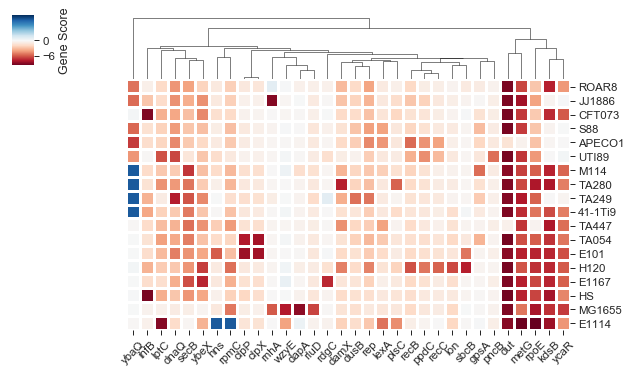

C:\Users\frousset\AppData\Local\conda\conda\envs\crispr\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


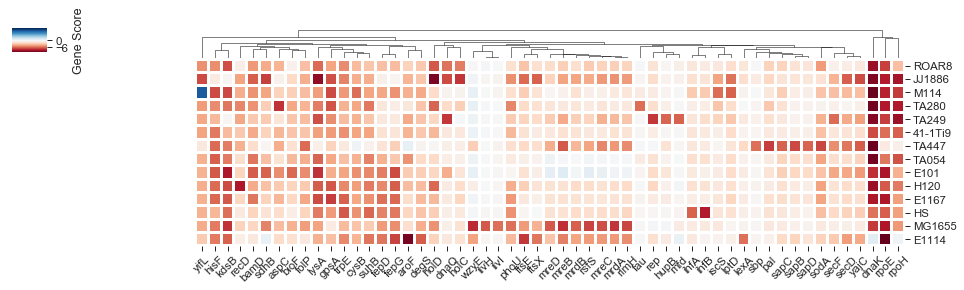

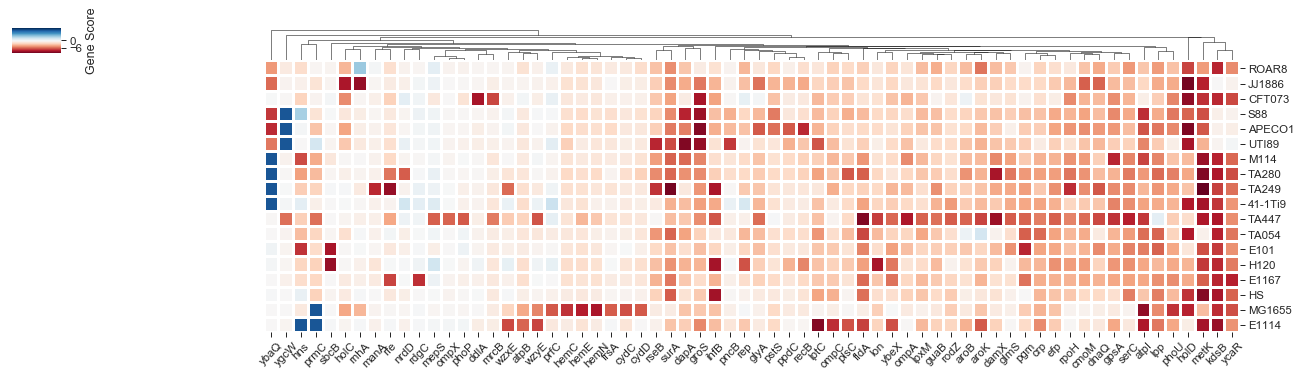

In [142]:
s={}
figsize=[(10,5.8),(16,4),(22,5.6)]
for i,medium in enumerate(['LB','M9','GMM']):
    heatmap=medians.loc[diff.loc[(diff['min_'+medium]<(-5))&(diff['max_'+medium]>(-1))].index]
    heatmap=heatmap[heatmap.gene_type=='CDS'].filter(regex=medium).drop('median_'+medium,axis=1)
    heatmap.columns=[c.split('_')[0] for c in heatmap.columns]
    strains=['ROAR8','JJ1886','CFT073','S88','APECO1','UTI89','M114','TA280','TA249','41-1Ti9','TA447','TA054','E101','H120','E1167','HS','MG1655','E1114']
    heatmap=heatmap.loc[:,strains].dropna(axis=1,how='all')#Put columns in the order of phylogeny
    g=sns.clustermap(heatmap.fillna(8).transpose(),cmap="RdBu",figsize=figsize[i],
                     vmin=heatmap.min().min(),vmax=-heatmap.min().min(),row_cluster=False,col_cluster=True,linewidths=2,
                     cbar_kws={"ticks":[-6,0],'label':'Gene Score'})
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)
    ax = g.ax_heatmap
    ax.set_xlabel("")
    plt.show()